In [24]:
import json
import logging
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

import colorlog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a color formatter
formatter = colorlog.ColoredFormatter(
    "%(log_color)s%(levelname)s: %(message)s",
    log_colors={
        "DEBUG": "cyan",
        "INFO": "green",
        "WARNING": "yellow",
        "ERROR": "red",
        "CRITICAL": "bold_red",
    },
)

# Create a logger
logger = logging.getLogger(__name__)  # Use module-level logger
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent propagation to root logger

# Remove all existing handlers (even from previous executions)
logger.handlers.clear()

# Create a stream handler and set the formatter
handler = logging.StreamHandler()
handler.setFormatter(formatter)

# Add the new handler
logger.addHandler(handler)

In [25]:
monitored_metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
data_types = ["ast_cfg", "ast", "cfg"]
base_folder = "../explanations"
columns = ["Data Type"] + monitored_metrics
sns.set_palette("tab10")

In [26]:
def get_json_files(directory):
    """Retrieves all JSON file paths in a given directory."""
    try:
        return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".json")]
    except FileNotFoundError:
        logger.warning(f"Directory not found: {directory}")
        return []


def load_json(file_path):
    """Loads a JSON file and returns its content."""
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            return json.load(file)
    except (json.JSONDecodeError, FileNotFoundError, KeyError) as e:
        logger.error(f"Error processing file '{file_path}': {e}")
        return None


def compute_category_metrics(directory, gt_category):
    """
    Computes Accuracy, Precision, Recall, and F1-score for a category using sklearn.

    :param directory: Path to the directory containing JSON log files.
    :param gt_category: The ground truth category.
    :return: Dictionary containing accuracy, precision, recall, and f1-score.
    """
    json_files = get_json_files(directory)
    total_files = len(json_files)

    if total_files == 0:
        return {"Accuracy": 0.0, "Precision": 0.0, "Recall": 0.0, "F1 Score": 0.0, "Total": 0}

    gt_category = gt_category.lower()
    y_true, y_pred = [], []

    for file in json_files:
        content = load_json(file)
        if not content:
            continue

        predicted_category = content.get("classification", "").lower()
        y_true.append(gt_category)
        y_pred.append(predicted_category)

    # Compute metrics using sklearn
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary", pos_label=gt_category, zero_division=0)
    recall = recall_score(y_true, y_pred, average="binary", pos_label=gt_category, zero_division=0)
    f1 = f1_score(y_true, y_pred, average="binary", pos_label=gt_category, zero_division=0)

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1, "Total": total_files}


def compute_overall_metrics(results):
    """
    Computes overall Accuracy, Precision, Recall, and F1-score across multiple categories.

    :param results: Dictionary of category-wise metric results.
    :return: Dictionary containing overall accuracy, precision, recall, and f1-score.
    """
    total_all = sum(res["Total"] for res in results.values())

    if total_all == 0:
        logger.warning("No JSON files found in any category.")
        return {"Accuracy": 0.0, "Precision": 0.0, "Recall": 0.0, "F1 Score": 0.0}

    # Weighted average of all metrics
    weighted_metrics = {key: sum(res[key] * res["Total"] for res in results.values()) / total_all for key in
                        monitored_metrics}

    return weighted_metrics

# Baseline

In [27]:
# List of Root Directories
baseline_folder = os.path.join(base_folder, "baseline_cv_1")
root_dirs = [os.path.join(baseline_folder, model_dir) for model_dir in os.listdir(baseline_folder) if os.path.isdir(os.path.join(baseline_folder, model_dir))]

# Process each root directory
baseline_results = {}
for root_dir in root_dirs:
    model_name = root_dir.split(os.sep)[-1]
    print(f"\nMODEL: {model_name}")

    # Automatically detect categories as subdirectories
    categories = {subdir: os.path.join(root_dir, subdir) for subdir in os.listdir(root_dir) if
                  os.path.isdir(os.path.join(root_dir, subdir))}

    # Collect all possible categories for FP/FN calculation
    all_categories = set(categories.keys())

    # Compute metrics for each category
    results = {category: compute_category_metrics(path, category) for category, path in
               categories.items()}

    # Compute overall metrics for this root directory
    overall_metrics = compute_overall_metrics(results)

    # Store per-directory results
    baseline_results[model_name] = overall_metrics

    # Print per-directory results
    for category, metrics in results.items():
        print(f"{category.capitalize()} - "
              f"Accuracy: {metrics['Accuracy']:.2%}, "
              f"Precision: {metrics['Precision']:.2%}, "
              f"Recall: {metrics['Recall']:.2%}, "
              f"F1: {metrics['F1 Score']:.2%} "
              f"({metrics['Total']} files)")

    print(f"Overall - "
          f"Accuracy: {overall_metrics['Accuracy']:.2%}, "
          f"Precision: {overall_metrics['Precision']:.2%}, "
          f"Recall: {overall_metrics['Recall']:.2%}, "
          f"F1: {overall_metrics['F1 Score']:.2%}")


MODEL: gpt-4o
Safe - Accuracy: 84.13%, Precision: 100.00%, Recall: 84.13%, F1: 91.38% (63 files)
Reentrant - Accuracy: 88.00%, Precision: 100.00%, Recall: 88.00%, F1: 93.62% (25 files)
Overall - Accuracy: 85.23%, Precision: 100.00%, Recall: 85.23%, F1: 92.02%

MODEL: o3-mini
Safe - Accuracy: 96.83%, Precision: 100.00%, Recall: 96.83%, F1: 98.39% (63 files)
Reentrant - Accuracy: 84.00%, Precision: 100.00%, Recall: 84.00%, F1: 91.30% (25 files)
Overall - Accuracy: 93.18%, Precision: 100.00%, Recall: 93.18%, F1: 96.37%

MODEL: gemini-1.5-flash
Safe - Accuracy: 93.65%, Precision: 100.00%, Recall: 93.65%, F1: 96.72% (63 files)
Reentrant - Accuracy: 36.00%, Precision: 100.00%, Recall: 36.00%, F1: 52.94% (25 files)
Overall - Accuracy: 77.27%, Precision: 100.00%, Recall: 77.27%, F1: 84.28%

MODEL: gemini-2.0-flash
Safe - Accuracy: 82.54%, Precision: 100.00%, Recall: 82.54%, F1: 90.43% (63 files)
Reentrant - Accuracy: 84.00%, Precision: 100.00%, Recall: 84.00%, F1: 91.30% (25 files)
Overall - 

In [28]:
def load_json(file_path):
    """Load a JSON file and return its contents."""
    logger.debug(f"Loading JSON file: {file_path}")
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        logger.error(f"Error loading JSON file {file_path}: {e}")
        return None


def get_ground_truth_from_path(contract_path):
    """Determine the ground truth label based on the parent folder name."""
    label = "reentrant" if "reentrant" in contract_path else "safe" if "safe" in contract_path else None
    return label


def collect_predictions(contract_dir):
    """Collect labels from JSON files (excluding classification.json)."""
    predictions = []
    files = [f for f in os.listdir(contract_dir) if f.endswith(".json") and f != "classification.json"]

    with ThreadPoolExecutor() as executor:
        future_to_file = {executor.submit(load_json, os.path.join(contract_dir, file)): file for file in files}
        for future in as_completed(future_to_file):
            data = future.result()
            if data and "label" in data:
                predictions.append(data["label"])

    return predictions


def process_contract(root):
    """Process a single contract directory."""
    ground_truth = get_ground_truth_from_path(root)
    classification_file = os.path.join(root, "classification.json")

    y_true_class, y_pred_class = None, None
    y_true_anal, y_pred_anal = [], []

    if os.path.exists(classification_file):
        classification_data = load_json(classification_file)
        contract_label = classification_data.get("classification", "").lower()

        if contract_label:
            y_true_class, y_pred_class = ground_truth, contract_label

        predictions = collect_predictions(root)
        y_true_anal = [ground_truth] * len(predictions)
        y_pred_anal = predictions

    return y_true_class, y_pred_class, y_true_anal, y_pred_anal


def compute_metrics(y_true, y_pred, metric_name):
    if not y_true:
        logger.warning(f"No data available for {metric_name} computation.")
        return 0, 0, 0, 0
    return (
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, pos_label="reentrant", average='binary'),
        recall_score(y_true, y_pred, pos_label="reentrant", average='binary'),
        f1_score(y_true, y_pred, pos_label="reentrant", average='binary')
    )


def evaluate(base_dir):
    """Compute accuracy, precision, recall, and F1-score for contract classification using parallel processing."""
    logger.debug(f"Starting evaluation on base directory: {base_dir}")

    contract_paths = [os.path.join(root) for root, _, _ in os.walk(base_dir) if
                      any(sub in root for sub in ["reentrant", "safe"])]

    y_true_analysis, y_pred_analysis = [], []
    y_true_classification, y_pred_classification = [], []

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_contract, root): root for root in contract_paths}
        for future in as_completed(futures):
            y_true_class, y_pred_class, y_true_anal, y_pred_anal = future.result()
            if y_true_class is not None:
                y_true_classification.append(y_true_class)
                y_pred_classification.append(y_pred_class)
            y_true_analysis.extend(y_true_anal)
            y_pred_analysis.extend(y_pred_anal)

    analysis_metrics = compute_metrics(y_true_analysis, y_pred_analysis, "analysis")
    classification_metrics = compute_metrics(y_true_classification, y_pred_classification, "classification")

    return analysis_metrics, classification_metrics


def process_results(base_directory):
    """Evaluate and extract analysis and classification metrics."""
    results = evaluate(base_directory)
    analysis_metrics, classification_metrics = results

    # Handle None values by replacing with NaN
    analysis_metrics = analysis_metrics if analysis_metrics else (np.nan, np.nan, np.nan, np.nan)
    classification_metrics = classification_metrics if classification_metrics else (np.nan, np.nan, np.nan, np.nan)

    return analysis_metrics, classification_metrics

# XRAG Models Evaluation

In [29]:
results_folder = os.path.join(base_folder, "xrag_cv_1")
base_directories = [os.path.join(results_folder, model_folder) for model_folder in os.listdir(results_folder) if os.path.isdir(os.path.join(results_folder, model_folder))]

# results_folder = os.path.join(base_folder, "k_analysis")
# base_directories += [os.path.join(results_folder, model_folder) for model_folder in os.listdir(results_folder)]
#
# results_folder = os.path.join(base_folder, "multirun_analysis")
# base_directories += [os.path.join(results_folder, model_folder) for model_folder in os.listdir(results_folder)]

# Dictionary to hold classification DataFrames for each model
classification_results = {}
analysis_results = {}

for base_directory in base_directories:
    analysis_data = []
    classification_data = []

    for dt in data_types:
        data_dir = os.path.join(base_directory, dt)
        analysis_metrics, classification_metrics = process_results(data_dir)

        analysis_data.append([dt] + list(analysis_metrics))
        classification_data.append([dt] + list(classification_metrics))

    # Create DataFrames for Analysis and Classification
    analysis_df = pd.DataFrame(analysis_data, columns=columns)
    classification_df = pd.DataFrame(classification_data, columns=columns)

    # Extract just the folder name from the path to use as a key
    model_name = base_directory.split(os.sep)[-1]

    # Store DataFrames in dictionaries
    analysis_results[model_name] = analysis_df
    classification_results[model_name] = classification_df

    # Display tables (optional)
    logger.info(f"Analysis Metrics for {model_name}")
    display(analysis_df)

    logger.info(f"Classification Metrics for {model_name}")
    display(classification_df)

INFO: Analysis Metrics for gpt-4o


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.490909,0.318681,0.696,0.437186
1,ast,0.490909,0.315985,0.680,0.431472
2,cfg,0.802273,0.646154,0.672,0.658824


INFO: Classification Metrics for gpt-4o


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.840909,0.648649,0.96,0.774194
1,ast,0.840909,0.648649,0.96,0.774194
2,cfg,0.875000,0.694444,1.00,0.819672


INFO: Analysis Metrics for o3-mini


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.490909,0.318681,0.696,0.437186
1,ast,0.490909,0.315985,0.680,0.431472
2,cfg,0.802273,0.646154,0.672,0.658824


INFO: Classification Metrics for o3-mini


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.909091,0.840,0.84,0.840000
1,ast,0.920455,0.875,0.84,0.857143
2,cfg,0.931818,0.880,0.88,0.880000


INFO: Analysis Metrics for gemini-1.5-flash


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.625000,0.384615,0.533333,0.446927
1,ast,0.628788,0.386139,0.520000,0.443182
2,cfg,0.806818,0.646341,0.706667,0.675159


INFO: Classification Metrics for gemini-1.5-flash


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.818182,0.8000,0.48,0.600000
1,ast,0.829545,0.8125,0.52,0.634146
2,cfg,0.875000,0.8500,0.68,0.755556


INFO: Analysis Metrics for gemini-2.0-flash


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.625000,0.384615,0.533333,0.446927
1,ast,0.628788,0.386139,0.520000,0.443182
2,cfg,0.806818,0.646341,0.706667,0.675159


INFO: Classification Metrics for gemini-2.0-flash


,Data Type,Accuracy,Precision,Recall,F1 Score
0,ast_cfg,0.761364,0.543478,1.0,0.704225
1,ast,0.772727,0.555556,1.0,0.714286
2,cfg,0.840909,0.641026,1.0,0.781250


# Effect of K Analysis

In [30]:
# List of models to compare
base_model = "gemini-1.5-flash"
models = [f"{base_model}_k{i}" for i in range(1, 8)]

# Extract only available models from classification_results
existing_models = [m for m in models if m in classification_results]

if existing_models:
    # Convert model names to numeric k-values for x-axis
    k_values = [int(model.split("_k")[-1]) for model in existing_models]

    for metric in monitored_metrics:
        plt.figure(figsize=(8, 5))

        # Plot one line per data_type
        for dt in data_types:
            y_values = []

            # Collect metric values for each k
            for model in existing_models:
                df = classification_results[model]
                value = df.loc[df["Data Type"] == dt, metric].values
                y_values.append(value[0] if len(value) > 0 else np.nan)

            plt.plot(k_values, y_values, marker='o', label=dt)

        plt.title(f"Effect of k on {metric} for {base_model} models")
        plt.ylim([0, 1])
        plt.xlabel("Value of k")
        plt.ylabel(metric)
        plt.xticks(k_values)  # Ensure k-values are properly shown
        plt.legend(title="Data Type", loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

# Effect of Data Type

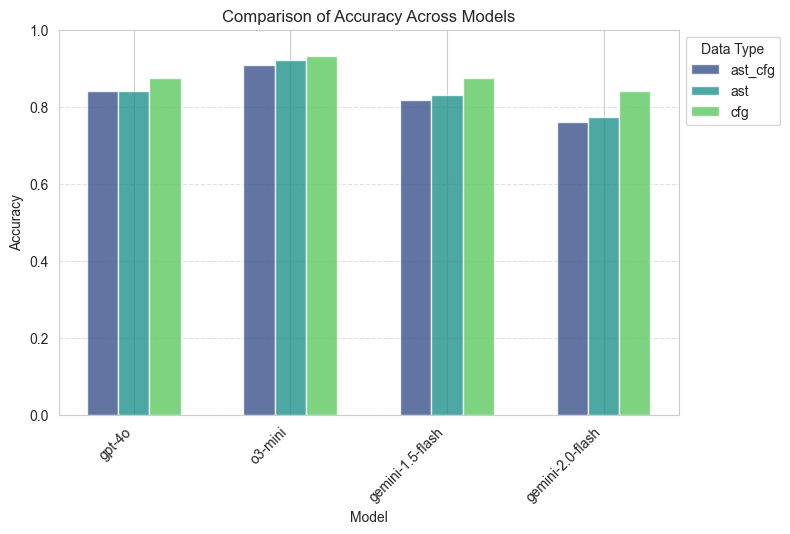

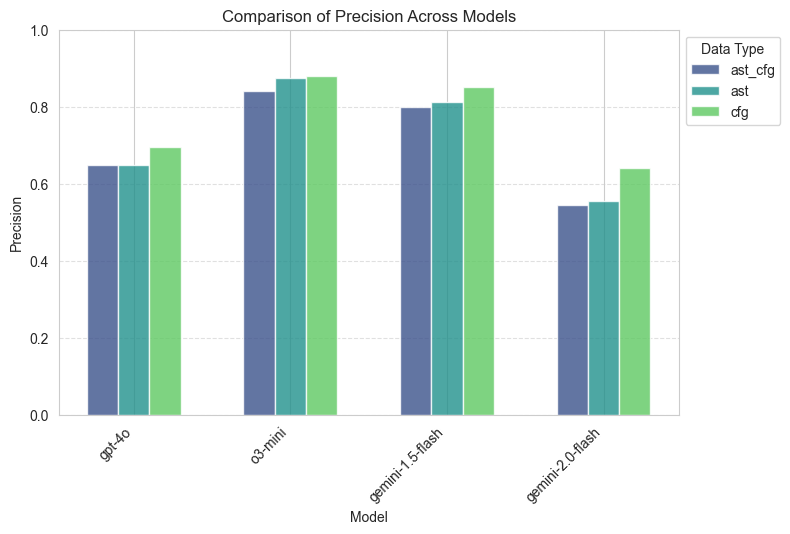

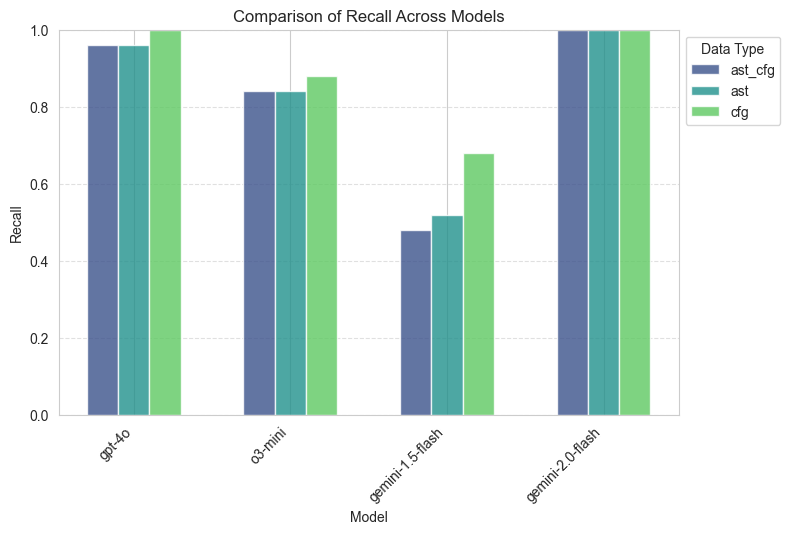

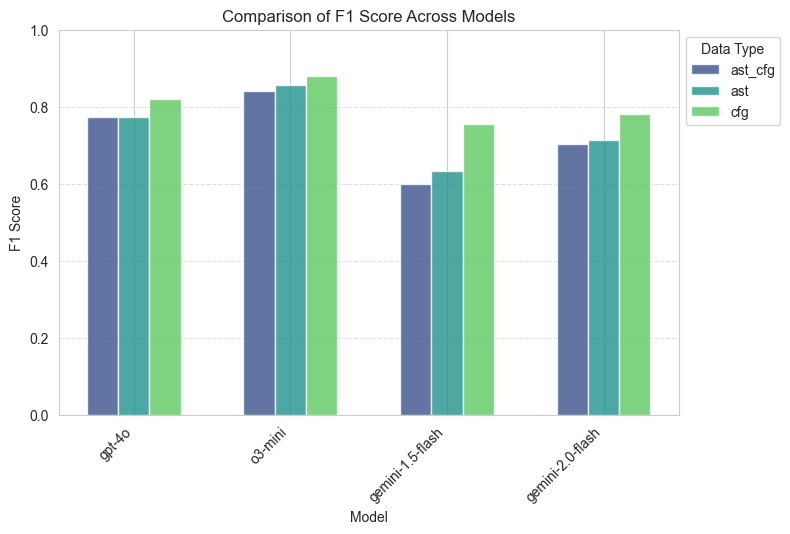

In [31]:
models = [m for m in classification_results.keys() if not ("_k" in m or m.startswith("r"))]

if models:
    for metric in monitored_metrics:
        plt.figure(figsize=(8, 5))

        x = np.arange(len(models))  # Positions for the models
        width = 0.2  # Width of each bar
        colors = sns.color_palette("viridis", len(data_types))  # Get distinct colors for each data type

        for i, (data_type, color) in enumerate(zip(data_types, colors)):
            values = [classification_results[model].loc[
                          classification_results[model]["Data Type"] == data_type, metric].values[0]
                      if data_type in classification_results[model]["Data Type"].values else np.nan
                      for model in models]
            plt.bar(x + i * width, values, width, label=data_type, alpha=0.8, color=color)

        # Formatting
        plt.ylim([0, 1])
        plt.xticks(x + width * (len(data_types) - 1) / 2, models, rotation=45, ha="right")
        plt.title(f"Comparison of {metric} Across Models")
        plt.xlabel("Model")
        plt.ylabel(metric)
        plt.legend(title="Data Type", loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()


# Models Comparison

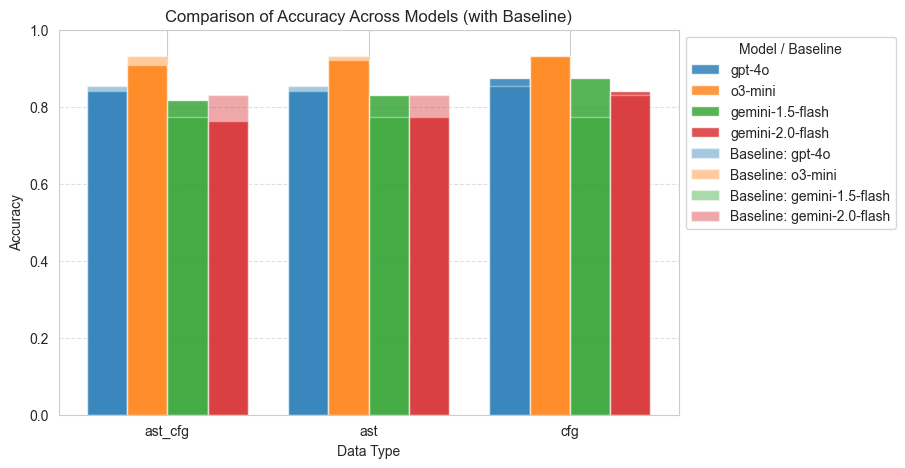

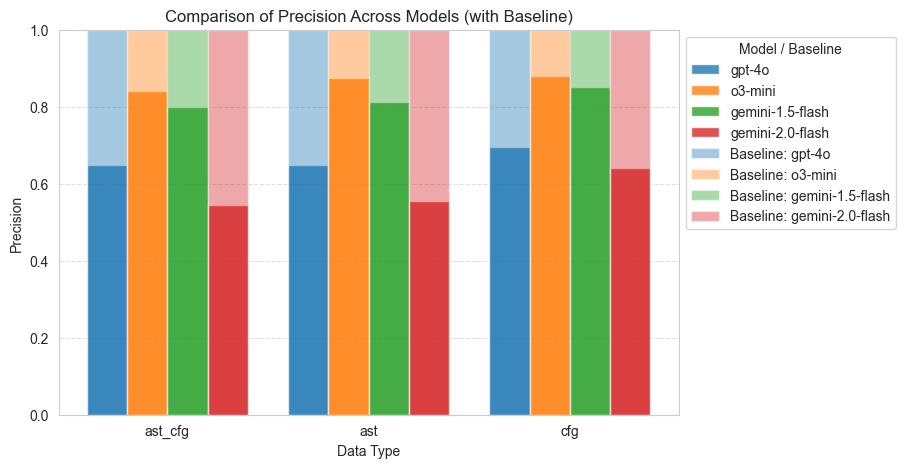

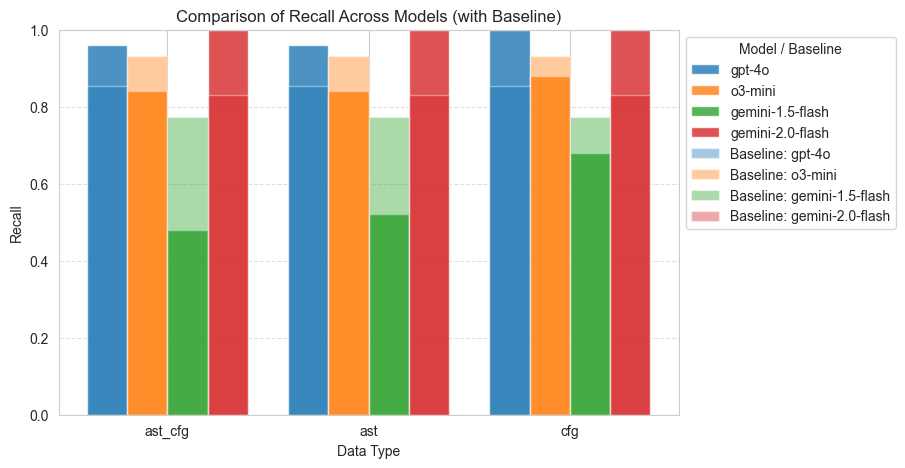

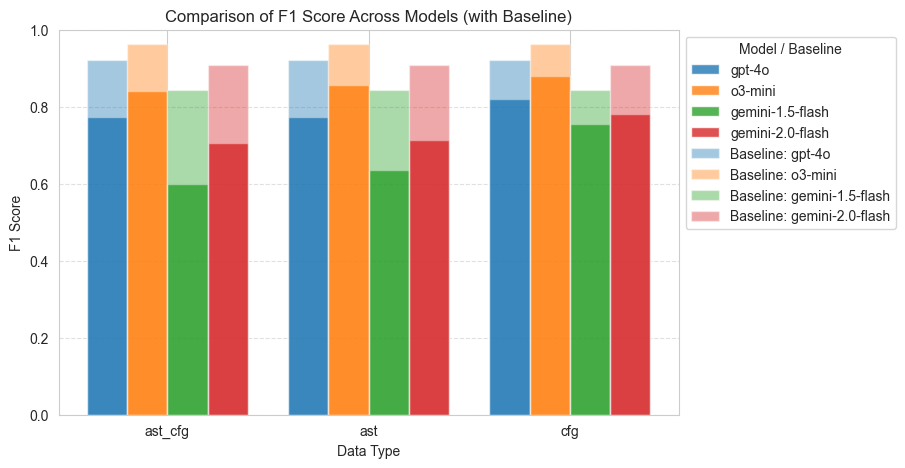

In [32]:
models = [m for m in classification_results.keys() if not ("_k" in m or m.startswith("r"))]

if models:
    for metric in monitored_metrics:
        plt.figure(figsize=(8, 5))

        x = np.arange(len(data_types))  # Positions for the data types
        width = 0.2  # Width of each bar
        model_colors = {}  # Store colors for each model

        for i, model in enumerate(models):
            df = classification_results[model]
            values = [df.loc[df["Data Type"] == dt, metric].values[0] if dt in df["Data Type"].values else np.nan
                      for dt in data_types]
            bars = plt.bar(x + i * width, values, width, label=model, alpha=0.8)
            model_colors[model] = bars[0].get_facecolor()  # Store the assigned color

        # Overlay baseline values with the same color but lower opacity
        for i, model in enumerate(models):
            baseline_values = [baseline_results.get(model, {}).get(metric, np.nan)] * len(data_types)
            plt.bar(x + i * width, baseline_values, width, label=f"Baseline: {model}", alpha=0.4,
                    color=model_colors.get(model, "gray"))

        # Formatting
        plt.ylim([0, 1])
        plt.xticks(x + width * (len(models) - 1) / 2, data_types)
        plt.title(f"Comparison of {metric} Across Models (with Baseline)")
        plt.xlabel("Data Type")
        plt.ylabel(metric)
        plt.legend(title="Model / Baseline", loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()